# Ch8: Tree-Based Methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

%matplotlib inline

In [2]:
import sklearn.model_selection as skm
import sklearn.linear_model as skl

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)

from sklearn.metrics import (accuracy_score,
                             log_loss,
                             precision_score,
                             recall_score,
                             make_scorer)

from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR,
      GradientBoostingClassifier as GBC)
     
from ISLP.bart import BART

from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

## Conceptual


### **Q1.**

We'll create a sketch with arbitrarily chosen cut points, 

$$
t_1 = 3,\quad t_2 = 40,\quad t_3 = 80
$$

$$
t_4 = -9,\quad t_5 =12
$$

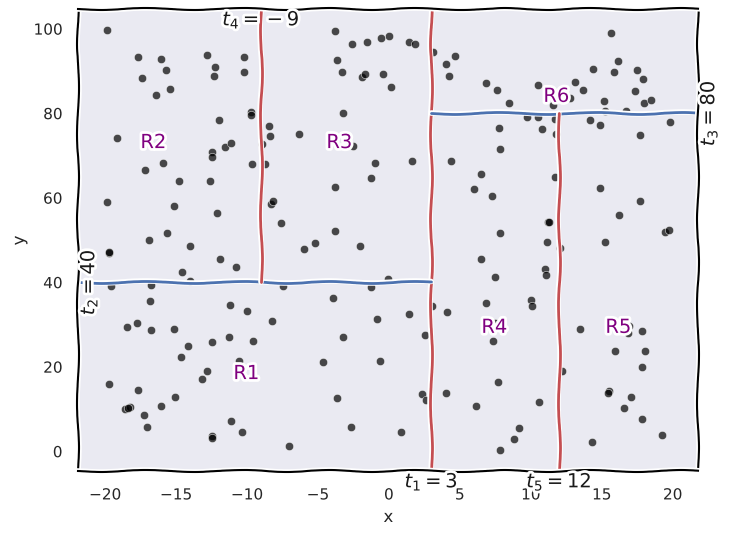

In [3]:
with plt.xkcd():
    plt.rcParams['font.family'] = 'DejaVu Sans' # to get rid of xkcd font warnings
    _, ax = plt.subplots(figsize=(8, 6))
    rng = np.random.default_rng(12)
    x = rng.uniform(-20, 20, 200)
    y = rng.uniform(0, 100, 200)
    
    sns.scatterplot(x=x, y=y, ax=ax, c='black', alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # 5 cuts
    t1 = 3 
    t2 = 40
    t3 = 80
    t4 = -9
    t5 = 12
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xrange = xlim[1] - xlim[0]
    yrange = ylim[1] - ylim[0]
     
    ax.axvline(t1, label='t1', c='r')
    ax.axhline(t2, xmax=(t1+xlim[1])/xrange, label='t2', c='b')
    ax.axhline(t3, xmin=(t1+xlim[1])/xrange, label='t3', c='b')
    ax.axvline(t4, ymin=(t2-ylim[0])/yrange, label='t4', c='r')
    ax.axvline(t5, ymax=(t3-ylim[0])/yrange, label='t5', c='r')
    
    # Annotate where the lines cut the axes:
    # For vertical lines
    ax.text(t1, ylim[0], f'$t_1={t1}$', ha='center', va='top', color='k')
    ax.text(t4, ylim[1], f'$t_4={t4}$', ha='center', va='top', color='k')
    ax.text(t5, ylim[0], f'$t_5={t5}$', ha='center', va='top', color='k')
    
    # For horizontal lines
    ax.text(xlim[0], t2, f'$t_2={t2}$', rotation=90, ha='left', va='center', color='k')
    ax.text(xlim[1], t3, f'$t_3={t3}$', rotation=90, ha='left', va='center', color='k')
    
    
    # Annotate regions
    ax.text(0.25, 0.2, 'R1', c='purple', transform=ax.transAxes)
    ax.text(0.1, 0.7, 'R2', c='purple', transform=ax.transAxes)
    ax.text(0.4, 0.7, 'R3', c='purple', transform=ax.transAxes)
    
    ax.text(0.65, 0.3, 'R4', c='purple', transform=ax.transAxes)
    ax.text(0.85, 0.3, 'R5', c='purple', transform=ax.transAxes)
    ax.text(0.75, 0.8, 'R6', c='purple', transform=ax.transAxes)


And the corresponding decision tree.

![Decision Tree](./images/decision_tree2.png)

### **Q2.**


Starting with equation (8.12): 

$$
\hat f(x) = \sum_{b = 1}^{B} \lambda \hat f^b(x)
$$


Since the number of splits is $1$, every tree (or stump in this case) makes a binary decision on one variable $X_j$, hence every model $\hat f^b(x)$ above can be written as the sum of binary models that take the form:

$$
f_j(X_j) = 
\begin{cases}
A_j, & \text{if } X_j \le t_j\\
B_j, & \text{if } X_j \gt t_j
\end{cases}
$$

Where $A_j$ and $B_j$ are arbitrary decisions for the $j\text{th}$ predictor, and $t_j$ is an arbitrary cut point.

And since the number of splits $d = 1$, for every iteration $b$ while fitting the boosting model, the $p$ functions above would all be $0$ except for the one chosen by the model.

$$
\hat f^b(X) = \sum_{j = 1}^{p} \hat f^b_j(X_j) 
$$

Where $\hat f^b_j(X_j) $ is the model in the $b\text{th}$ iteration that picked the $j\text{th}$ predictor. This would of course just be $\hat f_j(X_j)$ for some choice of $j$ in $[1, p]$.

Then substituing in (8.12)

$$
\hat f(X) = \sum_{b = 1}^{B} \lambda \sum_{j = 1}^{p} \hat f^b_j(X_j) 
$$

And summing up over all iterations while keeping the models for each predictor seperate we get:

$$
\hat f(X) = \sum_{j = 1}^{p} \hat f_j(X_j) 
$$

### **Q3.**


We can solve this by doing a math derivation and substituing for $\hat p_{m1} =  1 - \hat p_{m2}$, which makes the equations we have to plot simpler but it ultimately leads to the same result, so we'll just use the original equations with some numpy magic.

In [4]:
p1 = np.linspace(0.00000001, 0.99999999, 1000) # Not using 0 and 1 to avoid problems with np.log 
p = np.column_stack((p1, 1 - p1))

G = np.sum(p * (1-p), axis=1)
E = 1 - np.maximum(p1, 1 - p1)
D = -np.sum(p*np.log(p), axis=1)

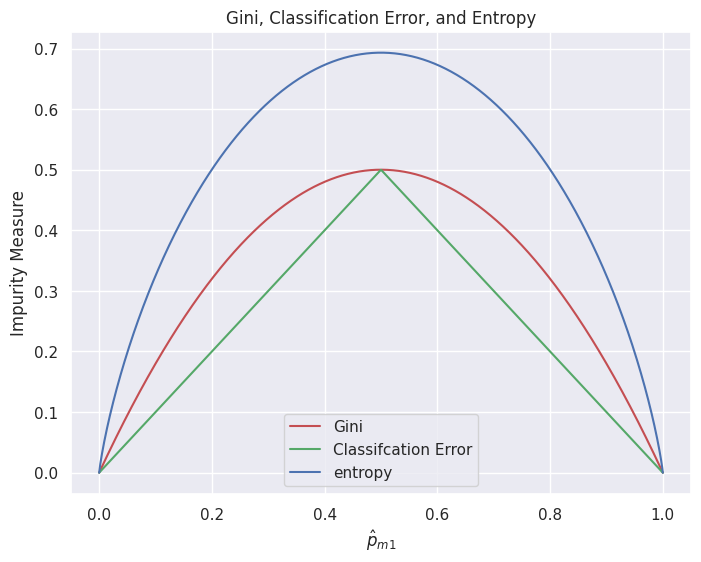

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(p1, G, c='r', label='Gini')
ax.plot(p1, E, c='g', label='Classifcation Error')
ax.plot(p1, D, c='b', label='entropy')

ax.set_xlabel('$\hat p_{m1}$')
ax.set_ylabel('Impurity Measure') 
ax.set_title('Gini, Classification Error, and Entropy')
ax.legend();

### **Q4.**


**(a)**


![Decision Tree](./images/decision_tree.png)

**(b)** We'll reuse the code from Q1 with slight modifications to plot the regions.

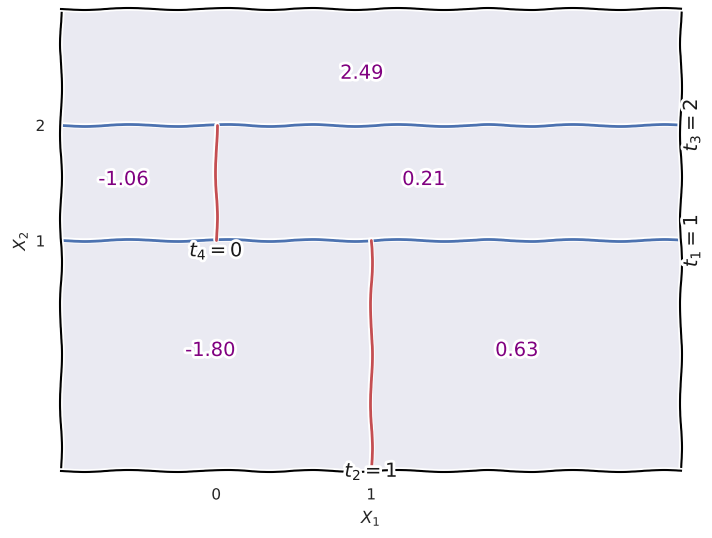

In [6]:
with plt.xkcd():
    plt.rcParams['font.family'] = 'DejaVu Sans' # to get rid of xkcd font warnings
    _, ax = plt.subplots(figsize=(8,6))
    rng = np.random.default_rng(12)
    x1 = rng.uniform(0, 2, 200)
    x2 = rng.uniform(0, 2, 200)
    
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    
    # 5 cuts
    t1 = 1
    t2 = 1
    t3 = 2
    t4 = 0
    
    ax.set_xticks([0, 1])
    ax.set_yticks([1, 2])
    xlim = [-1, 3]
    ylim = [-1, 3]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    xrange = xlim[1] - xlim[0]
    yrange = ylim[1] - ylim[0]
     
    ax.axhline(t1, label='t1', c='b')
    ax.axvline(t2, ymax=(t1-ylim[0])/yrange, label='t2', c='r')
    ax.axhline(t3, label='t3', c='b')
    ax.axvline(t4, ymin=(t1-ylim[0])/yrange,ymax=(t3-ylim[0])/yrange, label='t4', c='r')
    
    # Annotate where the lines cut the axes:
    # For vertical lines
    ax.text(t2, ylim[0], f'$t_2={t2}$', ha='center', va='center', color='k')
    ax.text(t4, t2, f'$t_4={t4}$', ha='center', va='top', color='k')    
    
    # For horizontal lines
    ax.text(xlim[1], t2, f'$t_1={t1}$', rotation=90, ha='left', va='center', color='k')
    ax.text(xlim[1], t3, f'$t_3={t3}$', rotation=90, ha='left', va='center', color='k')
    

    # Annotate regions
    ax.text(0.2, 0.25, '-1.80', c='purple', transform=ax.transAxes)
    ax.text(0.7, 0.25, '0.63', c='purple', transform=ax.transAxes)
    ax.text(0.45, 0.85, '2.49', c='purple', transform=ax.transAxes)
    ax.text(0.06, 0.62, '-1.06', c='purple', transform=ax.transAxes)
    ax.text(0.55, 0.62, '0.21', c='purple', transform=ax.transAxes)
    

### **Q5.**


In [7]:
p =  np.array([0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75])
p

array([0.1 , 0.15, 0.2 , 0.2 , 0.55, 0.6 , 0.6 , 0.65, 0.7 , 0.75])

We'll classify according to majority vote first, any probability greater than $0.5$ classifies as `Red` ($1$).

In [8]:
vote = np.where(p > 0.5, 1, 0)
np.unique(vote, return_counts=True)

(array([0, 1]), array([4, 6]))

$6$ votes for `Red` and $4$ votes for `Green`. 
Hence the classifer based on majority vote would pick `Red` for this value of $X$.

Now we'll classify according to the average probability.

In [9]:
p.mean()

0.45

The average probability is $0.45$ which means the classifier would pick `Green` given this value of $X$.

### **Q6.**


We'll start with Algorithm 8.1 from the book for building a regression tree and expand on the details in each step:

1. Use recursive binary splitting to grow a large tree on the training data, stopping only when each terminal node has fewer than some minimum number of observations.

    1. Start at the root node (the entire dataset).
    2. Chose a splitting point as follows:
       1. For each predictor and for every possible split point along that predictor, split the data into two regions:
          - Left, where it contains predictor values less than the splitting point.
          - Right, where it contains predictor values greater than the splitting point.
       2. Calculate the sum of squared errors (SSEs) for both regions for every splitting point and predictor used:

       $$
       SSE_{split} = \sum_{i \in L} (y_i - \bar y_{L})^2 + \sum_{i \in R} (y_i - \bar y_{R})^2
       $$

         - $R$: region on the right.
         - $L$: region on the left.
         - $y_i$: observed response.
         - $\bar y_{L}$ and $\bar y_{R}$: the average of the response values in the left and right regions respectively.
       3. Chose the split (predictor and point) that minimizes the SSE.
   1. Perform the chosen split on the data and append the two regions as left and right nodes to the root node.
   2. Recursion:
      1. Perform the same process (splitting and choosing a split) on every child node.
      2. Stop when each terminal node has fewer than some minimum number of observations.

2. Apply cost complexity pruning to the large tree in order to obtain a sequence of best subtrees, as a function of $\alpha$.
    1. Start with the inital large tree $T_0$.
    2. Repeatedly find the internal node where pruning its corresponding branch results in the smallest increase in RSS relative to number of leaves removed (n). 

    $$ 
    \alpha = \frac{\Delta Error}{n - 1}
    $$

    3. Prune the weakest link turning the entire branch into a terminal leaf.
    4. Store the newly pruned tree and its corresponding $\alpha$ value and repeat the pruning process above on this smaller tree.
    5. Continue until only the root node is left. This generates a sequence of trees $(T_0, T_1, ..., T_k)$ each $T_i$ being optimally pruned for a specific range $\left[\alpha_i, \alpha_{i+1} \right]$.
   

3. Use K-fold cross-validation to choose $\alpha$. That is, divide the training observations into $K$ folds. For each $k = 1, . . . , K$:
   
    1. Repeat Steps $1$ and $2$ on all but the $k\text{th}$ fold of the training data.
    2. Evaluate the mean squared prediction error on the data in the left-out $k\text{th}$ fold, as a function of $\alpha$.
    3. Average the results for each value of $\alpha$, and pick $\alpha$ to minimize the average error.

4. Return the subtree from Step $2$ that corresponds to the chosen value of $\alpha$

### **Q7.**

In [10]:
boston = load_data("Boston")
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [11]:
model = MS(boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(boston)
feature_names = list(D.columns)
X = np.asarray(D)
y = boston['medv']

In [12]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.3, random_state=1)

In [13]:
len(feature_names)

12

We'll fit random forest models and vary `max_features` from $1$ to $12$, and vary `n_estimators` from $1$ to $250$.

Note: this could take a few minutes to run.

In [14]:
test_per_m = {}
max_estimators = 250

for m in range(1, len(feature_names)+1): 
    test_per_m[m] = []
    for n in np.arange(1, max_estimators+1):
        rf_boston = RF(n_estimators=n, max_features=m, random_state=1)
        results = rf_boston.fit(X_train, y_train)
        error = np.mean((results.predict(X_test) - y_test)**2)
        test_per_m[m].append(error)

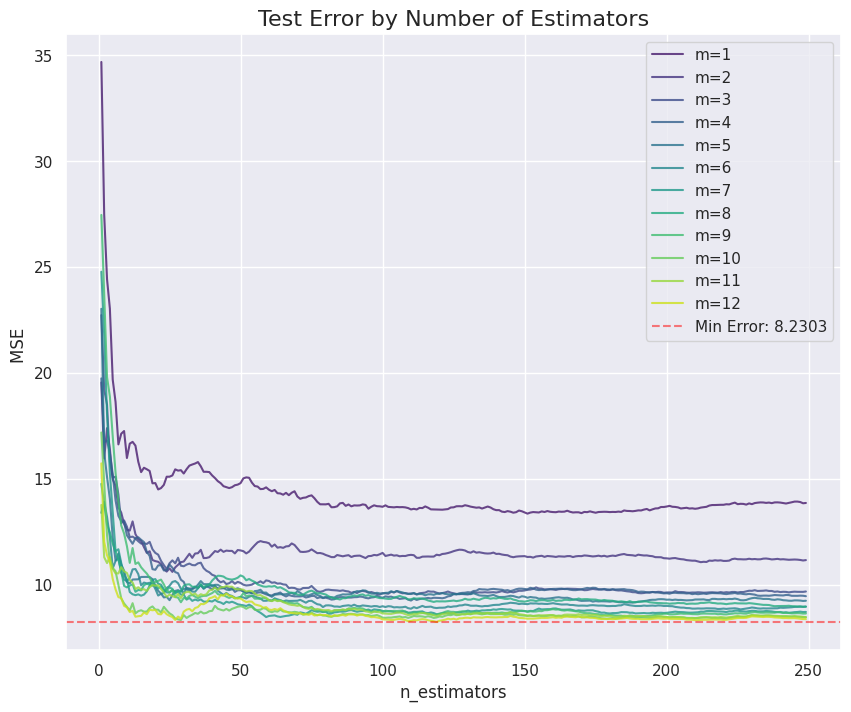

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
palette = sns.color_palette("viridis", len(test_per_m))

for m, test in test_per_m.items():
    
    sns.lineplot(x=np.arange(1, max_estimators),
                 y=test[1:],
                 label=f'm={m}',
                 ax=ax,
                 color=palette[m-1],
                 linewidth=1.5,
                 alpha=0.8)

# Add horizontal line at minimum error for reference
min_error = min([min(test[1:]) for test in test_per_m.values()])
ax.axhline(min_error, color='red', linestyle='--', alpha=0.5, 
           label=f'Min Error: {min_error:.4f}')

ax.set_title('Test Error by Number of Estimators', fontsize=16)
ax.set_xlabel('n_estimators')
ax.set_ylabel('MSE ')
ax.legend();

We notices that the test error doesn't take long to stabilize, and that for low values ($\lt 4)$ of `max_features` the model has significantly higher test error rates.

### **Q8.**


In [16]:
carseats = load_data('Carseats')
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


**(a)**

In [17]:
model = MS(carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(carseats)
feature_names = list(D.columns)
X = np.asarray(D)
y = carseats['Sales']

In [18]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.3, random_state=1)

**(b)**

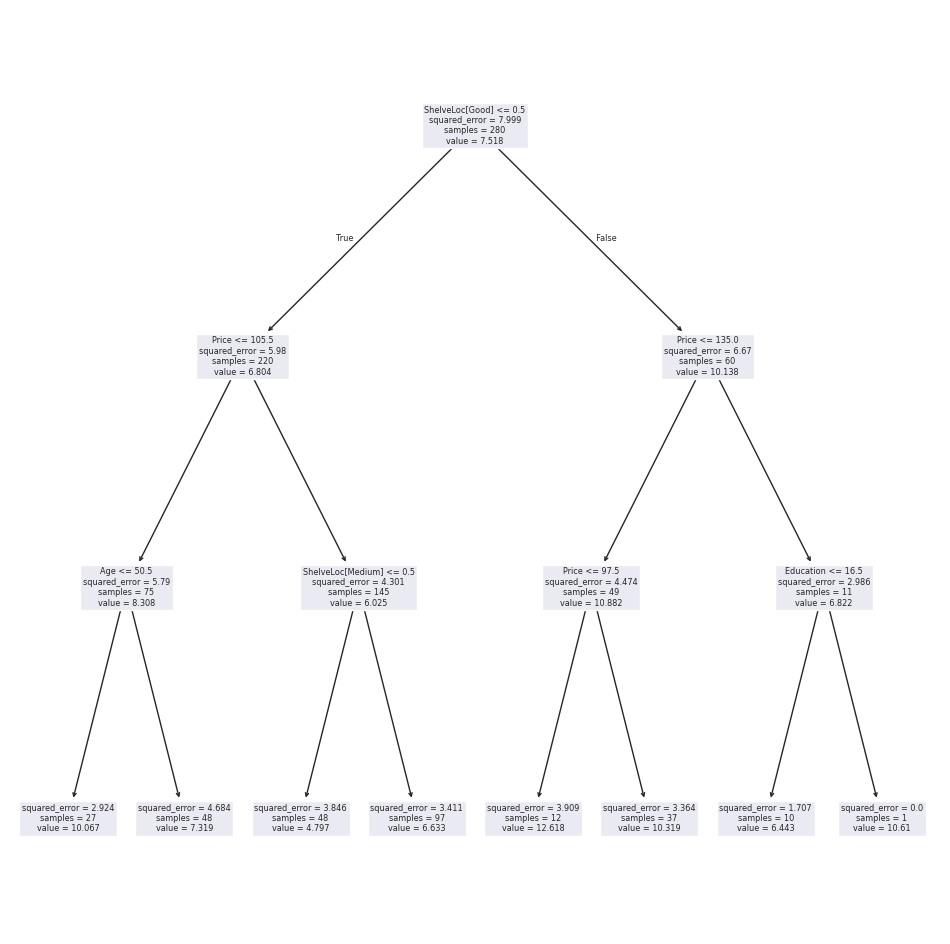

In [19]:
tree = DTR(max_depth=3, random_state=1)
results = tree.fit(X_train,  y_train)
plt.figure().set_size_inches(12, 12)
plot_tree(results, 
          feature_names=feature_names);

Test MSE:

In [20]:
np.mean((tree.predict(X_test) - y_test)**2)

4.725166009939633

**(c)**

In [21]:
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=2)

grid = skm.GridSearchCV(tree,
                        {'max_depth': np.arange(1, 20)},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')

G = grid.fit(X_train, y_train)
G.best_params_

{'max_depth': 3}

In [22]:
ccp_path = G.best_estimator_.cost_complexity_pruning_path(X_train, y_train)

grid = skm.GridSearchCV(G.best_estimator_,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')

G = grid.fit(X_train, y_train)
G.best_params_

{'ccp_alpha': 0.0}

In [23]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

4.725166009939633

No improvement from pruning the tree.

**(d)** Bagging:

In [24]:
bagging_carseats = RF(n_estimators=500,
                      max_features=X_train.shape[1],
                      random_state=1).fit(X_train, y_train)
np.mean((bagging_carseats.predict(X_test) - y_test)**2)

2.843689088653341

We got a test MSE of $2.8437$ which is an improvement from the single regression tree.

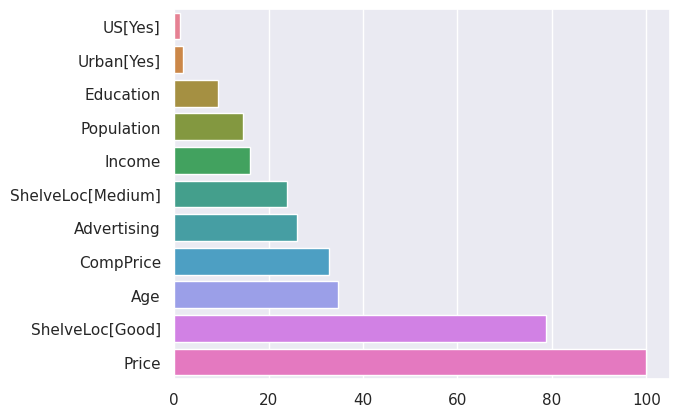

In [25]:
feature_imp = pd.DataFrame(
    {'importance':bagging_carseats.feature_importances_},
    index=feature_names)
sns.barplot(feature_imp.sort_values(by='importance').T * 100/feature_imp['importance'].max(), orient='h');

The two most important features to determine `Sales` are `Price` and `ShelveLoc[Good]` (indicates good quality of the shelving location for the car seats).

You can also read more about the data [here](https://islp.readthedocs.io/en/latest/datasets/Carseats.html).

**(e)** Random forests:

In [26]:
test_errors = []
best_rf = None
for m in np.arange(1, X_train.shape[1]+1):
    rf_carseats = RF(n_estimators=500,
                        max_features=m,
                        random_state=1).fit(X_train, y_train)
    
    error = np.mean((rf_carseats.predict(X_test) - y_test)**2)
    test_errors.append(error)
    
    if error == min(test_errors):
        best_rf = rf_carseats

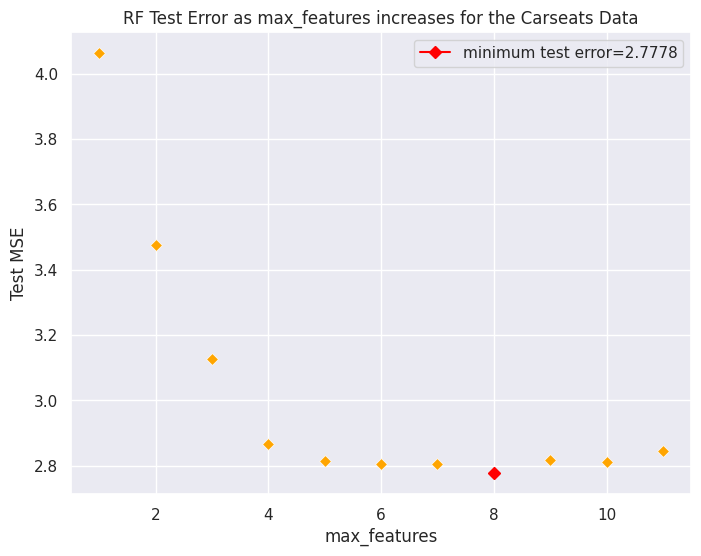

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=np.arange(1, X_train.shape[1]+1), y=test_errors, ax=ax, c='orange', marker='D')
ax.plot(np.argmin(test_errors)+1, min(test_errors), c='red', marker='D', label=f'minimum test error={min(test_errors):.4f}')
ax.set_title('RF Test Error as max_features increases for the Carseats Data', ha='center')
ax.set_xlabel('max_features')
ax.set_ylabel('Test MSE')
ax.legend();

We can see that the test error rapidly decreases as `max_features` goes down, stabilising at around $m = 5$ but minimized at $8$, we also notice that it rises up a bit after $8$ too. 

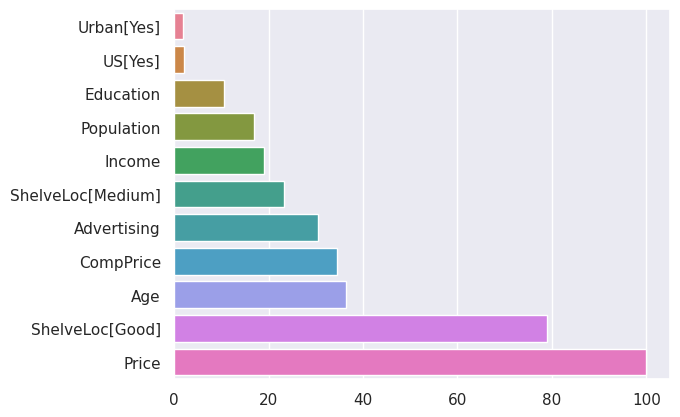

In [28]:
feature_imp = pd.DataFrame(
    {'importance':best_rf.feature_importances_},
    index=feature_names)
sns.barplot(feature_imp.sort_values(by='importance').T * 100/feature_imp['importance'].max(), orient='h');

Again we see the same variables emphasized by the model.

**(f)** BART:

In [29]:
bart_carseats = BART(random_state=0, burnin=100, ndraw=1000)
bart_carseats.fit(X_train, y_train)

BART(ndraw=1000, random_state=0)

In [30]:
np.mean((bart_carseats.predict(X_test) - y_test)**2)

1.4032862543324767

The BART method performed even better on this data than all the previous methods.

We'll plot the `variable_inclusion` means and scale them by $100$ which can serve as measures of importance here.

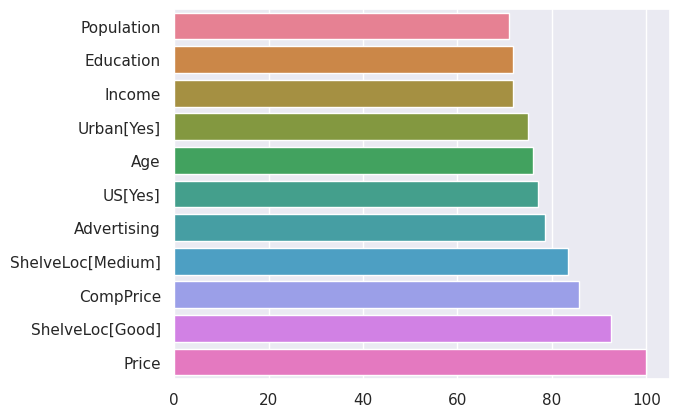

In [31]:
var_inclusion = pd.DataFrame(
    {'inclusion':bart_carseats.variable_inclusion_.mean(0)},
    index=D.columns)
sns.barplot(var_inclusion.sort_values(by='inclusion').T * (100 / var_inclusion['inclusion'].max()), orient='h');

Again the model emphasized the `Price` and `ShelveLoc[Good]` variables. 

### **Q9.** 

Note: decision tree algorithms are pretty sensitive to changes in `random_state` make sure to always have it set whether in the cross-validation folds or the tree itself.


In [32]:
oj = load_data('OJ')
oj.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [33]:
oj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Purchase        1070 non-null   category
 1   WeekofPurchase  1070 non-null   int64   
 2   StoreID         1070 non-null   int64   
 3   PriceCH         1070 non-null   float64 
 4   PriceMM         1070 non-null   float64 
 5   DiscCH          1070 non-null   float64 
 6   DiscMM          1070 non-null   float64 
 7   SpecialCH       1070 non-null   int64   
 8   SpecialMM       1070 non-null   int64   
 9   LoyalCH         1070 non-null   float64 
 10  SalePriceMM     1070 non-null   float64 
 11  SalePriceCH     1070 non-null   float64 
 12  PriceDiff       1070 non-null   float64 
 13  Store7          1070 non-null   category
 14  PctDiscMM       1070 non-null   float64 
 15  PctDiscCH       1070 non-null   float64 
 16  ListPriceDiff   1070 non-null   float64 
 17  STORE         

In [34]:
oj.describe()

,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000
mean,254.381308,3.959813,1.867421,2.085411,0.051860,0.123364,0.147664,0.161682,0.565782,1.962047,1.815561,0.146486,0.059298,0.027314,0.217991,1.630841
std,15.558286,2.308984,0.101970,0.134386,0.117474,0.213834,0.354932,0.368331,0.307843,0.252697,0.143384,0.271563,0.101760,0.062232,0.107535,1.430387
min,227.000000,1.000000,1.690000,1.690000,0.000000,0.000000,0.000000,0.000000,0.000011,1.190000,1.390000,-0.670000,0.000000,0.000000,0.000000,0.000000
25%,240.000000,2.000000,1.790000,1.990000,0.000000,0.000000,0.000000,0.000000,0.325257,1.690000,1.750000,0.000000,0.000000,0.000000,0.140000,0.000000
50%,257.000000,3.000000,1.860000,2.090000,0.000000,0.000000,0.000000,0.000000,0.600000,2.090000,1.860000,0.230000,0.000000,0.000000,0.240000,2.000000
75%,268.000000,7.000000,1.990000,2.180000,0.000000,0.230000,0.000000,0.000000,0.850873,2.130000,1.890000,0.320000,0.112676,0.000000,0.300000,3.000000
max,278.000000,7.000000,2.090000,2.290000,0.500000,0.800000,1.000000,1.000000,0.999947,2.290000,2.090000,0.640000,0.402010,0.252688,0.440000,4.000000


In [35]:
oj.describe(include='category')

,Purchase,Store7
count,1070,1070
unique,2,2
top,CH,No
freq,653,714


**(a)**

In [36]:
model = MS(oj.columns.drop('Purchase'), intercept=False)
D = model.fit_transform(oj)
feature_names = list(D.columns)
X = np.asarray(D)
y = oj['Purchase']

In [37]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, train_size=800, shuffle=True, random_state=1)

**(b)**

In [38]:
tree = DTC(random_state=2)
results = tree.fit(X_train, y_train)
results

DecisionTreeClassifier(random_state=2)

Classification training error rate:

In [39]:
1 - results.score(X_train, y_train)

0.010000000000000009

Very clearly overfitting since no `max_depth` was specified.

**(c)**

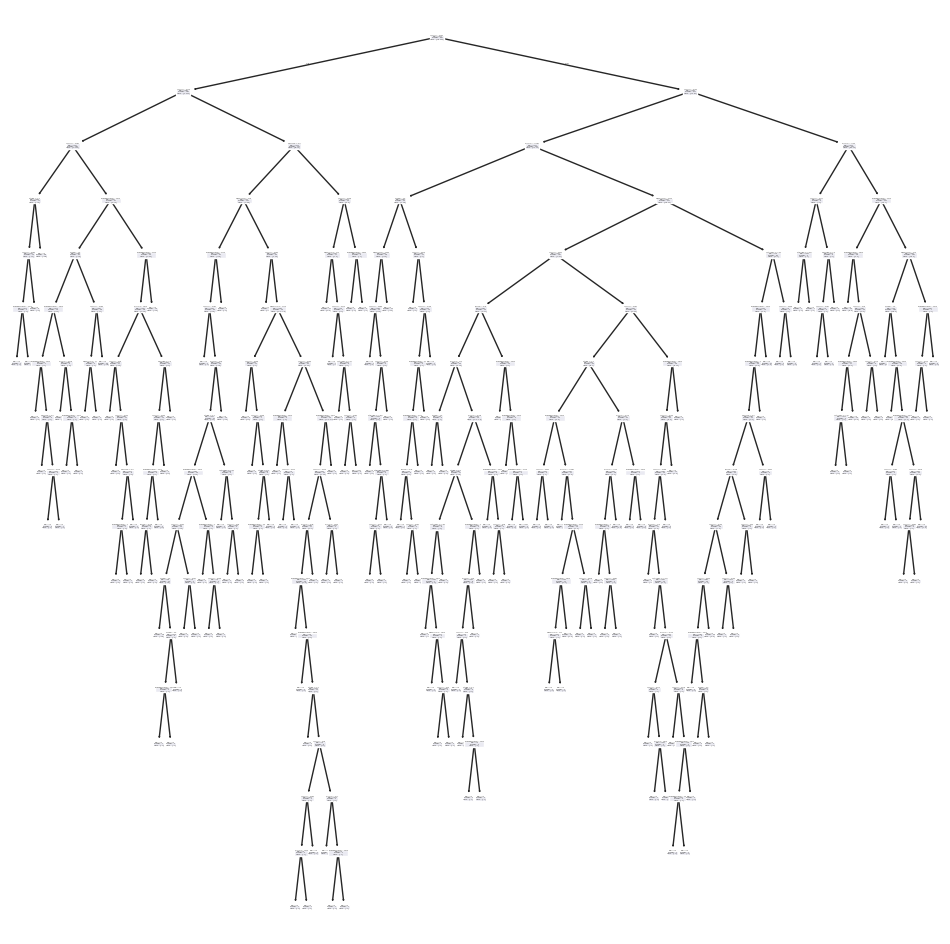

In [40]:
plt.figure().set_size_inches(12, 12)
plot_tree(tree, 
          feature_names=feature_names);

A lot of terminal nodes...

In [41]:
tree.get_n_leaves()

164

164 to be specific.

**(d)**

In [42]:
print(export_text(tree, feature_names=feature_names))

|--- LoyalCH <= 0.45
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.05
|   |   |   |--- StoreID <= 2.50
|   |   |   |   |--- LoyalCH <= 0.00
|   |   |   |   |   |--- WeekofPurchase <= 269.50
|   |   |   |   |   |   |--- class: CH
|   |   |   |   |   |--- WeekofPurchase >  269.50
|   |   |   |   |   |   |--- class: MM
|   |   |   |   |--- LoyalCH >  0.00
|   |   |   |   |   |--- class: MM
|   |   |   |--- StoreID >  2.50
|   |   |   |   |--- class: MM
|   |   |--- LoyalCH >  0.05
|   |   |   |--- WeekofPurchase <= 249.50
|   |   |   |   |--- STORE <= 1.50
|   |   |   |   |   |--- WeekofPurchase <= 235.50
|   |   |   |   |   |   |--- WeekofPurchase <= 232.00
|   |   |   |   |   |   |   |--- class: MM
|   |   |   |   |   |   |--- WeekofPurchase >  232.00
|   |   |   |   |   |   |   |--- SpecialCH <= 0.50
|   |   |   |   |   |   |   |   |--- class: CH
|   |   |   |   |   |   |   |--- SpecialCH >  0.50
|   |   |   |   |   |   |   |   |--- LoyalCH <= 0.22
|   |   |   |   |   |   |   |   

I'm choosing the first terminal node since it's the easiest to parse.

```
|--- LoyalCH <= 0.45
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.05
|   |   |   |--- StoreID <= 2.50
|   |   |   |   |--- LoyalCH <= 0.00
|   |   |   |   |   |--- WeekofPurchase <= 269.50
|   |   |   |   |   |   |--- class: CH
```

We go to the variable `LoyalCH` if it's less than or equal to $0.45$ we go left, we do this to more times with values $0.28$, $0.05$, then we check if `StoreID` is less than or equal to $2.50$ if it is we go left, then if `LoyalCH` is less than or equal to $0$ we go left and finally if `WeekofPurchase` is less than or equal to $269.5$ we go left and classify the observation as `CH`.

**(e)**

In [43]:
y_pred = results.predict(X_test)
confusion_table(y_pred, y_test)

Truth,CH,MM
Predicted,,
CH,132,40
MM,25,73


The test error rate is:

In [44]:
1 - accuracy_score(y_test, y_pred)

0.2407407407407407

**(f)**

In [45]:
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=6)

grid = skm.GridSearchCV(tree,
                        {'max_depth': np.arange(1, 100)},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')

grid = grid.fit(X_train, y_train)
grid.best_params_

{'max_depth': 3}

The optimal tree size is $3$.

In [46]:
best_tree = grid.best_estimator_
y_pred = best_tree.predict(X_test)
confusion_table(y_pred, y_test)

Truth,CH,MM
Predicted,,
CH,139,31
MM,18,82


**(g)**

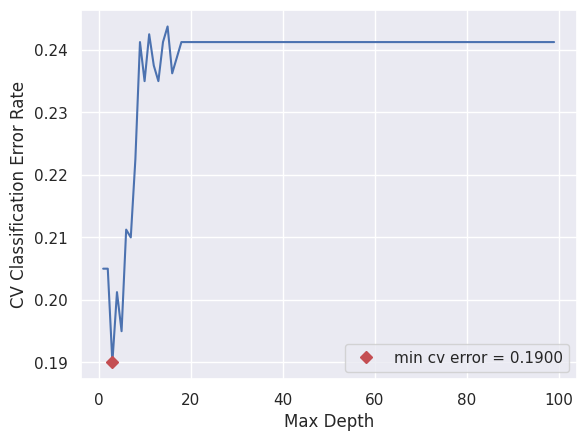

In [47]:
x = grid.cv_results_['param_max_depth'].data # tree depth
y = 1 - grid.cv_results_['mean_test_score'] # classification error rate = 1 - accuracy

_, ax = plt.subplots()
sns.lineplot(x=x,
             y=y,
             ax=ax)

ax.plot(x[np.argmin(y)], y.min(), 'Dr', label=f'min cv error = {y.min():.4f}')
ax.set_xlabel('Max Depth')
ax.set_ylabel('CV Classification Error Rate')
ax.legend();

**(h)**

A tree of size 3 has the lowest cv classification error rate.

In [48]:
x[np.argmin(y)]

3

And $8$ terminal nodes.

In [49]:
best_tree.get_n_leaves()

8

**(i)**

Now we'll prune the tree of size 3 we obtained from cross validation.

In [50]:
ccp_path = best_tree.cost_complexity_pruning_path(X_train, y_train)

kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=3)

grid = skm.GridSearchCV(best_tree,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')

grid = grid.fit(X_train, y_train)
grid.best_params_, grid.best_estimator_.get_n_leaves()

({'ccp_alpha': 0.014143149663851926}, 4)

Cross validation leads to the selection of a pruned tree with $4$ terminal nodes.

In [51]:
pruned_tree = grid.best_estimator_

**(j)** Training error rate:

For the unpruned tree with $8$ terminal nodes.

In [52]:
1 - best_tree.score(X_train, y_train)

0.15249999999999997

For the pruned tree with $4$ terminal nodes.

In [53]:
1 - pruned_tree.score(X_train, y_train)

0.16500000000000004

We can see that the training error rate for the **pruned tree** is higher.

**(k)** Test error rate:

For the unpruned tree with $8$ terminal nodes.

In [54]:
y_pred = best_tree.predict(X_test)
1 - accuracy_score(y_test, y_pred)

0.18148148148148147

For the pruned tree with $4$ terminal nodes.

In [55]:
y_pred = pruned_tree.predict(X_test)
1 - accuracy_score(y_test, y_pred)

0.18148148148148147

They're exactly the same.

### **Q10.**


In [56]:
hitters = load_data('Hitters')
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [57]:
hitters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   AtBat      322 non-null    int64   
 1   Hits       322 non-null    int64   
 2   HmRun      322 non-null    int64   
 3   Runs       322 non-null    int64   
 4   RBI        322 non-null    int64   
 5   Walks      322 non-null    int64   
 6   Years      322 non-null    int64   
 7   CAtBat     322 non-null    int64   
 8   CHits      322 non-null    int64   
 9   CHmRun     322 non-null    int64   
 10  CRuns      322 non-null    int64   
 11  CRBI       322 non-null    int64   
 12  CWalks     322 non-null    int64   
 13  League     322 non-null    category
 14  Division   322 non-null    category
 15  PutOuts    322 non-null    int64   
 16  Assists    322 non-null    int64   
 17  Errors     322 non-null    int64   
 18  Salary     263 non-null    float64 
 19  NewLeague  322 non-null    ca

In [58]:
hitters.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,263.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,535.925882
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,451.118681
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,190.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,425.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000


In [59]:
hitters.describe(include='category')

,League,Division,NewLeague
count,322,322,322
unique,2,2,2
top,A,W,A
freq,175,165,176


**(a)**


In [60]:
hitters['Salary'].isna().sum()

59

59 null values in the `Salary` column, we'll proceed by dropping them.

In [61]:
hitters.dropna(subset=['Salary'], inplace=True)
hitters['Salary'].isna().sum()

0

Now we'll log-transform the salaries.

In [62]:
hitters['Salary'] = np.log(hitters['Salary'])
hitters['Salary'].describe()

count    263.000000
mean       5.927222
std        0.889192
min        4.212128
25%        5.247024
50%        6.052089
75%        6.620073
max        7.807917
Name: Salary, dtype: float64

**(b)**


In [63]:
model = MS(hitters.columns.drop('Salary'), intercept=False)
D = model.fit_transform(hitters)
feature_names = list(D.columns)
X = np.asarray(D)
y = hitters['Salary']

In [64]:
X_train, y_train = X[:200], y[:200]
X_test, y_test = X[200:], y[200:]

**(c)**


We'll perform boosting with `1000` trees and a $100$ values for the shrinkage paramater ranging from `0.0001` to `0.1`.

In [65]:
lambdas = np.linspace(0.0001, 0.2, 100, endpoint=True)
train_errors = np.zeros_like(lambdas)
test_errors = np.zeros_like(lambdas)

min_error = np.infty
best_booster = None

for idx, lam in enumerate(lambdas):
    boost_hitters = GBR(n_estimators=1000,
                    learning_rate=lam,
                    max_depth=3,
                    random_state=1)
    boost_hitters.fit(X_train, y_train)
    
    train_errors[idx] = np.mean((y_train - boost_hitters.predict(X_train))**2)
    test_errors[idx] = np.mean((y_test - boost_hitters.predict(X_test))**2)
    
    if test_errors[idx] < min_error:
        best_booster = boost_hitters
        min_error = test_errors[idx]

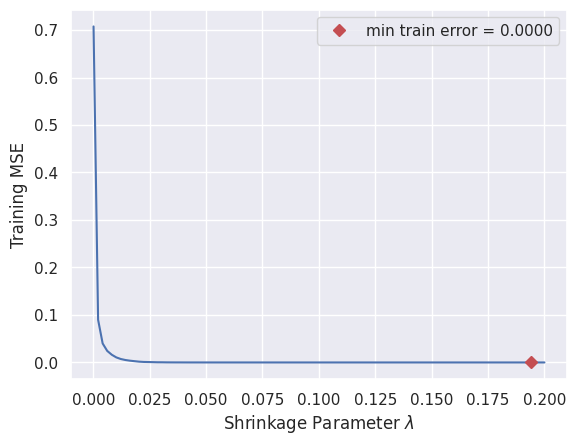

In [66]:
x = lambdas
y = train_errors
_, ax = plt.subplots()
sns.lineplot(x=x,
             y=y,
             ax=ax)

ax.plot(x[np.argmin(y)], y.min(), 'Dr', label=f'min train error = {y.min():.4f}')
ax.set_xlabel('Shrinkage Parameter $\\lambda$')
ax.set_ylabel('Training MSE')
ax.legend();

Shrinkage value that minimizes train MSE.

In [67]:
x[np.argmin(y)]

0.19394242424242425

**(d)**


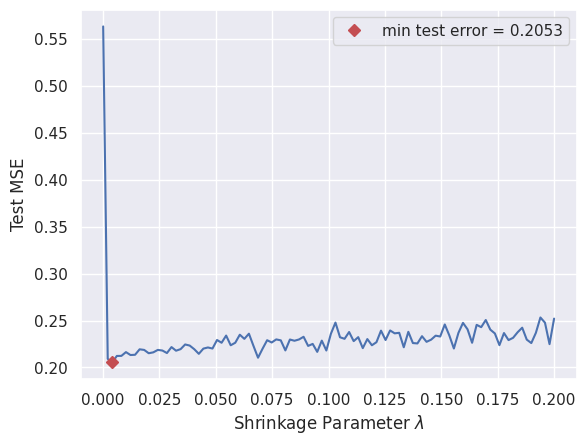

In [68]:
x = lambdas
y = test_errors
_, ax = plt.subplots()
sns.lineplot(x=x,
             y=y,
             ax=ax)

ax.plot(x[np.argmin(y)], y.min(), 'Dr', label=f'min test error = {y.min():.4f}')
ax.set_xlabel('Shrinkage Parameter $\\lambda$')
ax.set_ylabel('Test MSE')
ax.legend();

In [69]:
boost_MSE = test_errors.min()
boost_MSE

0.20530216513114846

Shrinkage value that minimizes test MSE.

In [70]:
x[np.argmin(y)]

0.004138383838383839

**(e)**


We'll apply linear regression and the lasso methods to the data to see how they compare to boosting.

Linear regression test MSE:

In [71]:
lr = skl.LinearRegression().fit(X_train, y_train)
lr_MSE = np.mean((lr.predict(X_test) - y_test)**2)
lr_MSE

0.4917959375454946

In [72]:
kfold = skm.KFold(n_splits=5,
               shuffle=True,
               random_state=2)

scaler = StandardScaler()

lassoCV = skl.ElasticNetCV(l1_ratio=1,
                           cv=kfold,
                           max_iter=2000)

pipeCV = Pipeline([('scaler', scaler),
                ('lasso', lassoCV)])
pipeCV.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 ElasticNetCV(cv=KFold(n_splits=5, random_state=2, shuffle=True),
                              l1_ratio=1, max_iter=2000))])

Lasso test MSE:

In [73]:
lasso_MSE = np.mean((pipeCV.predict(X_test) - y_test)**2)
lasso_MSE

0.4710027646164625

Now we'll compare their RMSE:

In [74]:
print(f"Boosting RMSE: {np.sqrt(boost_MSE):.4f}")
print(f"Linear Regression RMSE: {np.sqrt(lr_MSE):.4f}")
print(f"Lasso RMSE: {np.sqrt(lasso_MSE):.4f}")

Boosting RMSE: 0.4531
Linear Regression RMSE: 0.7013
Lasso RMSE: 0.6863


We can see that while their test RMSE is still within one standard deviation of the mean, linear regression and the lasso perform much worse on this data set than boosting does.

In [75]:
hitters['Salary'].std(), hitters['Salary'].mean()

(0.8891923883918419, 5.927221541221392)

**(f)**


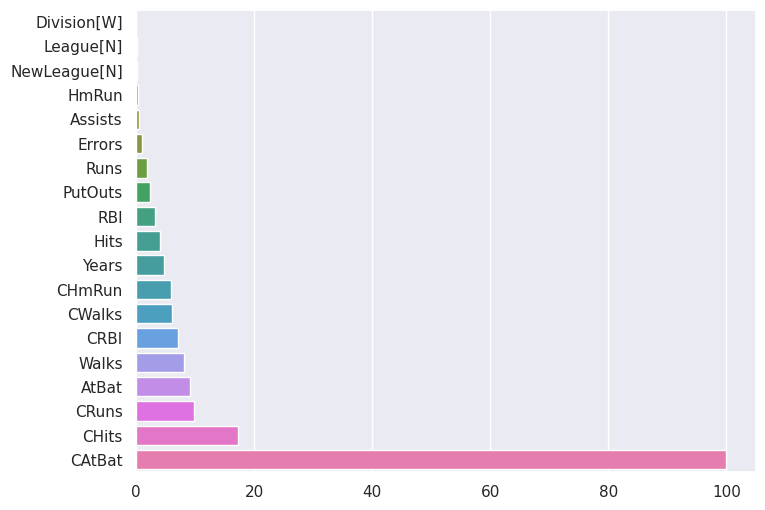

In [76]:
feature_imp = pd.DataFrame(
    {'importance':best_booster.feature_importances_},
    index=feature_names)

plt.figure().set_size_inches(8, 6)
sns.barplot(feature_imp.sort_values(by='importance', ascending=True).T * 100/feature_imp['importance'].max(), orient='h');

The `CAtBat` (Number of times at bat during his career) predictor seems to be the most important when predicting `Salary` for the boosted model.

To understand what the other predictors mean you can go to this [page](https://islp.readthedocs.io/en/latest/datasets/Hitters.html).

**(g)**


In [77]:
bagging_hitters = RF(n_estimators=500,
                    max_features=X_train.shape[1],
                    random_state=1).fit(X_train, y_train)
np.mean((bagging_hitters.predict(X_test) - y_test)**2)

0.2296193952740068

We got a test MSE of $0.2296$ with bagging which is slightly higher than the best test MSE we got with boosting $0.2053$.

### **Q11.**


In [78]:
caravan = load_data('Caravan')
caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In [79]:
caravan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 86 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   MOSTYPE   5822 non-null   int64   
 1   MAANTHUI  5822 non-null   int64   
 2   MGEMOMV   5822 non-null   int64   
 3   MGEMLEEF  5822 non-null   int64   
 4   MOSHOOFD  5822 non-null   int64   
 5   MGODRK    5822 non-null   int64   
 6   MGODPR    5822 non-null   int64   
 7   MGODOV    5822 non-null   int64   
 8   MGODGE    5822 non-null   int64   
 9   MRELGE    5822 non-null   int64   
 10  MRELSA    5822 non-null   int64   
 11  MRELOV    5822 non-null   int64   
 12  MFALLEEN  5822 non-null   int64   
 13  MFGEKIND  5822 non-null   int64   
 14  MFWEKIND  5822 non-null   int64   
 15  MOPLHOOG  5822 non-null   int64   
 16  MOPLMIDD  5822 non-null   int64   
 17  MOPLLAAG  5822 non-null   int64   
 18  MBERHOOG  5822 non-null   int64   
 19  MBERZELF  5822 non-null   int64   
 20  MBERBOER

In [80]:
caravan.describe()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
count,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,...,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000
mean,24.253349,1.110615,2.678805,2.991240,5.773617,0.696496,4.626932,1.069907,3.258502,6.183442,...,0.076606,0.005325,0.006527,0.004638,0.570079,0.000515,0.006012,0.031776,0.007901,0.014256
std,12.846706,0.405842,0.789835,0.814589,2.856760,1.003234,1.715843,1.017503,1.597647,1.909482,...,0.377569,0.072782,0.080532,0.077403,0.562058,0.022696,0.081632,0.210986,0.090463,0.119996
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,1.000000,3.000000,3.000000,7.000000,0.000000,5.000000,1.000000,3.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,1.000000,3.000000,3.000000,8.000000,1.000000,6.000000,2.000000,4.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41.000000,10.000000,5.000000,6.000000,10.000000,9.000000,9.000000,5.000000,9.000000,9.000000,...,8.000000,1.000000,1.000000,2.000000,7.000000,1.000000,2.000000,3.000000,2.000000,2.000000


In [81]:
caravan.describe(include='category')

,Purchase
count,5822
unique,2
top,No
freq,5474


**(a)**

In [82]:
model = MS(caravan.columns.drop('Purchase'), intercept=False)
D = model.fit_transform(caravan)
feature_names = list(D.columns)
X = np.asarray(D)
y = caravan['Purchase']

In [83]:
X_train, X_test = X[:1000], X[1000:]
y_train, y_test = y[:1000], y[1000:]
len(X_train), len(X_test), len(y_train), len(y_test)

(1000, 4822, 1000, 4822)

**(b)**

In [84]:
gbc_caravan = GBC(n_estimators=1000,
                  learning_rate=0.01,
                  random_state=1)
gbc_results = gbc_caravan.fit(X_train, y_train)

Now we'll create a feature importance plot and scale it so that the highest value is 100.

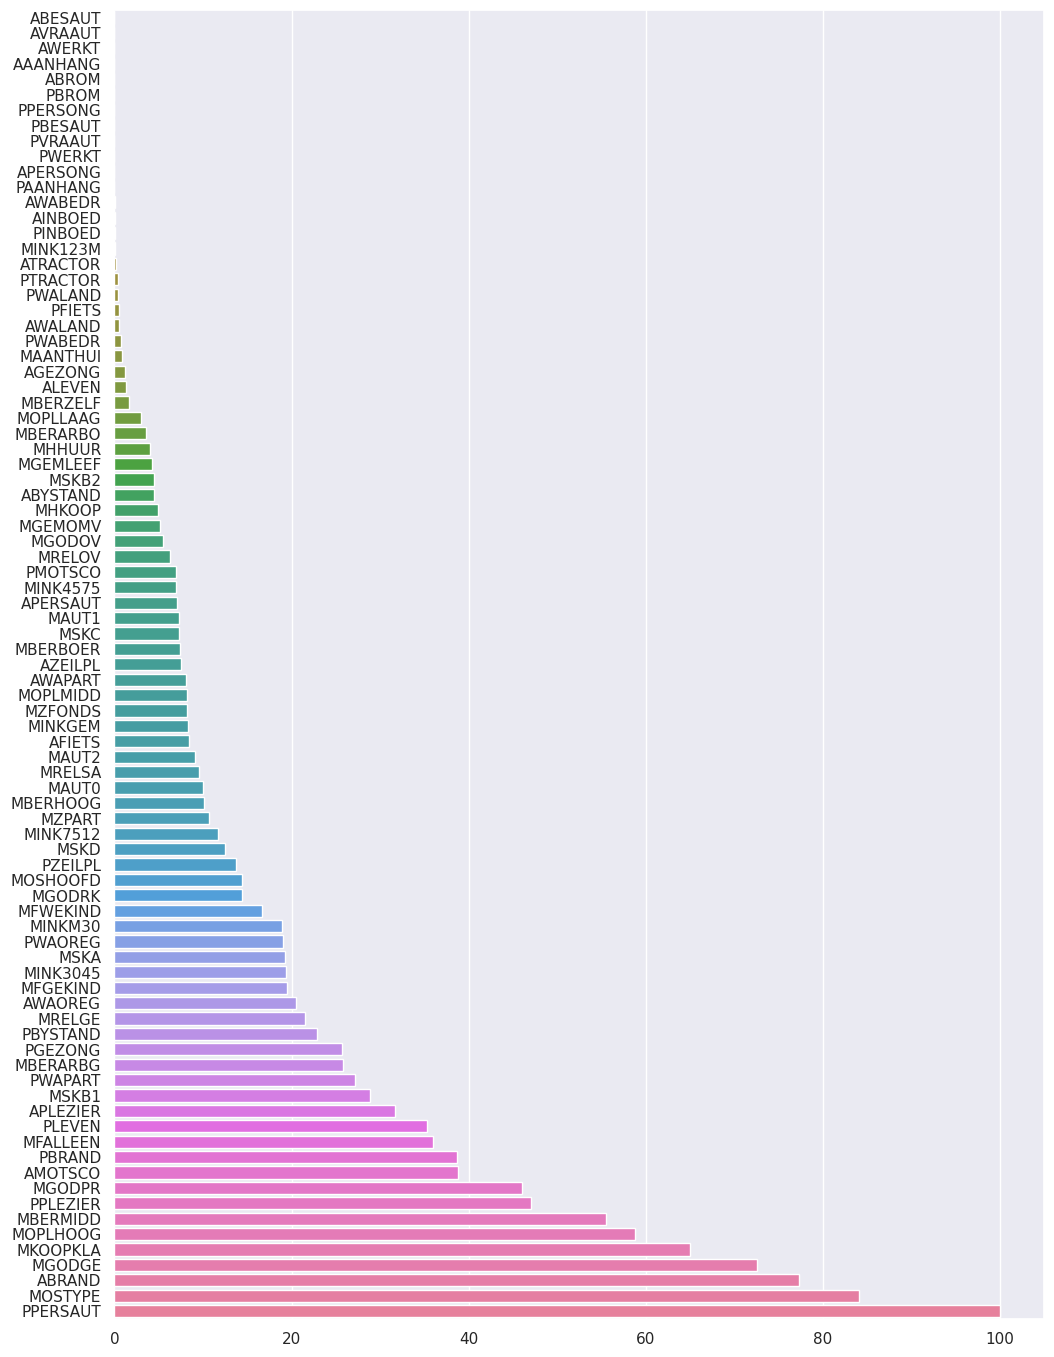

In [85]:
feature_imp = pd.DataFrame(
    {'importance':gbc_results.feature_importances_},
    index=feature_names)

plt.figure().set_size_inches(12, 17)
sns.barplot(feature_imp.sort_values(by='importance', ascending=True).T * 100/feature_imp['importance'].max(), orient='h');

We can see that `PPERSAUT` is the most important feature in our data (this variable refers to the customer's Contribution Car Policies, it quantifies the level of contribution a car customer makes towards insurance policies where $0$ means he doesn't contribute much to car policies and $1$ to $8$ are varying levels of contribution).

To read more about the [data](https://liacs.leidenuniv.nl/~puttenpwhvander/library/cc2000/data.html).

We can also see multiple features with high importance values.

**(c)**

In [86]:
y_prob = gbc_results.predict_proba(X_test)
y_pred = np.where(y_prob[:,1] > 0.2, 'Yes', 'No')

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label='Yes'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label='Yes'):.4f}")

confusion_table(y_pred, y_test)

Accuracy: 0.9072998755703028
Precision: 0.1653
Recall: 0.1349


Truth,No,Yes
Predicted,,
No,4336,250
Yes,197,39


The fraction of people predicted to make a purchase that do in fact make one (the precision) is:

$$
Precision = 0.1653
$$

Now we'll fit a KNN and a LogisticRegression model to compare them against the Boosting model.

First the KNN model. We'll use cross-validation to choose the number of neighbors and try to maximize the precision score.

In [87]:
knn = KNN()
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=2)

custom_scorer = make_scorer(precision_score, pos_label='Yes', zero_division=0)

grid = skm.GridSearchCV(knn,
                        {'n_neighbors': np.arange(1, 20)},
                        cv=kfold,
                        scoring=custom_scorer).fit(X_train, y_train)
grid.best_params_

{'n_neighbors': 4}

In [88]:
y_pred = grid.best_estimator_.predict(X_test)

print(f"KNN Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"KNN Precision: {precision_score(y_test, y_pred, pos_label='Yes'):.4f}")
print(f"KNN Recall: {recall_score(y_test, y_pred, pos_label='Yes'):.4f}")

confusion_table(y_pred, y_test)

KNN Accuracy: 0.9376
KNN Precision: 0.2000
KNN Recall: 0.0138


Truth,No,Yes
Predicted,,
No,4517,285
Yes,16,4


Now for logistic regression. 

In [89]:
lr = skl.LogisticRegression(fit_intercept=True, max_iter=1000)
lr_results = lr.fit(X_train, y_train)

y_prob = lr_results.predict_proba(X_test)
y_pred = np.where(y_prob[:,1] > 0.2, 'Yes', 'No')

print(f"LR Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"LR Precision: {precision_score(y_test, y_pred, pos_label='Yes'):.4f}")
print(f"LR Recall: {recall_score(y_test, y_pred, pos_label='Yes'):.4f}")

confusion_table(y_pred, y_test)

LR Accuracy: 0.9015
LR Precision: 0.1771
LR Recall: 0.1765


Truth,No,Yes
Predicted,,
No,4296,238
Yes,237,51


We can see that KNN and logistic regression do pretty well on this data set, and can achieve results comparable to or even better than boosting here, however the choice of the best model mostly depends on business needs, for this type of problem picking the model with the higher `precision` or `recall` depends on how expensive missing a potential buyer or targeting a non-buyer (assuming postive predictions get some form of specialized marketing or offers) is for the business. 

### **Q12.**

We'll answer this question for the `Credit` dataset from the ISLP package, for info on the dataset click [here](https://islp.readthedocs.io/en/latest/datasets/Credit.html).

In [90]:
credit = load_data('Credit')
credit.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [91]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         400 non-null    int64   
 1   Income     400 non-null    float64 
 2   Limit      400 non-null    int64   
 3   Rating     400 non-null    int64   
 4   Cards      400 non-null    int64   
 5   Age        400 non-null    int64   
 6   Education  400 non-null    int64   
 7   Gender     400 non-null    category
 8   Student    400 non-null    category
 9   Married    400 non-null    category
 10  Ethnicity  400 non-null    category
 11  Balance    400 non-null    int64   
dtypes: category(4), float64(1), int64(7)
memory usage: 27.2 KB


In [92]:
credit.describe()

,ID,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,200.500000,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,115.614301,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,1.000000,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,100.750000,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,200.500000,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,300.250000,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,400.000000,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


In [93]:
credit.describe(include='category')

,Gender,Student,Married,Ethnicity
count,400,400,400,400
unique,2,2,2,3
top,Female,No,Yes,Caucasian
freq,207,360,245,199


We'll use `Balance` as our response variable which represents average credit card balance in USD. 

In [94]:
model = MS(credit.columns.drop('Balance'), intercept=False)
D = model.fit_transform(credit)
feature_names = list(D.columns)
X = np.asarray(D)
y = credit['Balance']

In [95]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.3, random_state=1)

Boosting:


In [96]:
credit_boost = GBR(n_estimators=1000,
                    random_state=1).fit(X_train, y_train)
boost_MSE = np.mean((y_test - credit_boost.predict(X_test))**2)
boost_MSE

8938.816355567129

Bagging:


In [97]:
credit_bagging = RF(n_estimators=1000, 
                    max_features=X_train.shape[1],
                    random_state=1).fit(X_train, y_train)
bagging_MSE = np.mean((y_test - credit_bagging.predict(X_test))**2)
bagging_MSE

14346.337228441666

Random Forests ($m = \sqrt{p}$):

In [98]:
credit_rf = RF(n_estimators=1000, 
               max_features='sqrt',
               random_state=1).fit(X_train, y_train)
rf_MSE = np.mean((y_test - credit_rf.predict(X_test))**2)
rf_MSE

28888.775582383332

BART:

In [99]:
credit_bart = BART(random_state=1, burnin=300, ndraw=1000).fit(X_train, y_train)
bart_MSE = np.mean((y_test - credit_bart.predict(X_test))**2)
bart_MSE

13270.316940363333

Linear Regression:

In [100]:
lr = skl.LinearRegression().fit(X_train, y_train)
lr_MSE = np.mean((y_test - lr.predict(X_test))**2)
lr_MSE

11660.013638016124

In [101]:
print(f"Boosting RMSE         : {np.sqrt(boost_MSE):.4f}")
print(f"Bagging RMSE          : {np.sqrt(bagging_MSE):.4f}")
print(f"Random Forests RMSE   : {np.sqrt(rf_MSE):.4f}")
print(f"BART RMSE             : {np.sqrt(bart_MSE):.4f}")
print(f"Linear Regression RMSE: {np.sqrt(lr_MSE):.4f}")

Boosting RMSE         : 94.5453
Bagging RMSE          : 119.7762
Random Forests RMSE   : 169.9670
BART RMSE             : 115.1969
Linear Regression RMSE: 107.9815


In [102]:
credit['Balance'].mean(), credit['Balance'].std()

(520.015, 459.75887738938314)

We can see that **boosting** does the best on this dataset with no parameter fine-tuning, surprisingly though linear regression comes in 2nd place with an RMSE of $107$, while the other tree methods lag pretty far behind, which indicates that there might be strong linearities in the underlying relationships.